In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures 

import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('flight_delay.csv')                                                         # Loading the data
print(data.shape)

(675513, 5)


In [3]:
data.head(10)                                                                                  # Exploring the data

,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay
0,SVO,2015-10-27 07:40:00,HAV,2015-10-27 20:45:00,0.0
1,SVO,2015-10-27 09:50:00,JFK,2015-10-27 20:35:00,2.0
2,SVO,2015-10-27 10:45:00,MIA,2015-10-27 23:35:00,0.0
3,SVO,2015-10-27 12:30:00,LAX,2015-10-28 01:20:00,0.0
4,OTP,2015-10-27 14:15:00,SVO,2015-10-27 16:40:00,9.0
5,HAM,2015-10-27 14:30:00,SVO,2015-10-27 17:15:00,0.0
6,SVO,2015-10-27 14:35:00,JFK,2015-10-28 01:25:00,0.0
7,DXB,2015-10-27 15:40:00,SVO,2015-10-27 21:20:00,1.0
8,SVO,2015-10-27 16:10:00,VVO,2015-10-28 00:35:00,0.0
9,TLV,2015-10-27 16:45:00,SVO,2015-10-27 20:55:00,0.0


# Extract valuable data

In [4]:
data['Departure'] = pd.to_datetime(data['Scheduled depature time'])                          # Extracting the departure time
data['Arrival'] = pd.to_datetime(data['Scheduled arrival time'])                             # Extracting the arrival time

data['Flight duration'] = (data['Arrival'] - data['Departure']).dt.seconds /60               # Calculating the flight duration

data['Departure date'] = data['Departure'].dt.date                                           # Extracting dates
data['Arrival date'] = data['Arrival'].dt.date

data['Departure time'] = data['Departure'].dt.time                                           # Extracting times
data['Arrival time'] = data['Arrival'].dt.time

data = data.drop(columns=['Scheduled arrival time', 'Scheduled depature time'])

In [5]:
data['Departure month'] = data['Departure date'].map(lambda x: x.month)                       # Extracting month, day and hour
data['Arrival month'] = data['Arrival date'].map(lambda x: x.month)

data['Departure day'] = data['Departure date'].map(lambda x: x.day)
data['Arrival day'] = data['Arrival date'].map(lambda x: x.day)

data['Departure hour'] = data['Departure time'].map(lambda x: x.hour)
data['Arrival hour'] = data['Arrival time'].map(lambda x: x.hour)

In [6]:
values = ["First week","Second week","Third week","Fourth week"]                              # Mapping the day to four categories to "reduce" features

criteria = [data['Arrival day'].between(1, 7), data['Arrival day'].between(8, 14), data['Arrival day'].between(15, 21), data['Arrival day'].between(22, 31)]
data['Arrival week'] = np.select(criteria, values, 0)

criteria = [data['Departure day'].between(1, 7), data['Departure day'].between(8, 14), data['Departure day'].between(15, 21), data['Departure day'].between(22, 31)]
data['Departure week'] = np.select(criteria, values, 0)

In [7]:
values = ["Morning","Day","Night"]                                                             # Mapping the hour to three categories to "reduce" features

criteria = [data['Departure hour'].between(0, 8), data['Departure hour'].between(8, 16), data['Departure hour'].between(16, 24)]
data['Departure hour'] = np.select(criteria, values, 0)

criteria = [data['Arrival hour'].between(0, 8), data['Arrival hour'].between(8, 16), data['Arrival hour'].between(16, 24)]
data['Arrival hour'] = np.select(criteria, values, 0)

In [8]:
data = data.drop(columns=['Departure time', 'Departure', 'Departure day', 'Arrival time','Arrival date','Arrival', 'Arrival day'])

In [9]:
data.isnull().sum()                                                                             # Not nan values

Depature Airport       0
Destination Airport    0
Delay                  0
Flight duration        0
Departure date         0
Departure month        0
Arrival month          0
Departure hour         0
Arrival hour           0
Arrival week           0
Departure week         0
dtype: int64

In [10]:
data.shape                                                                                      # Check the initial size of the data

(675513, 11)

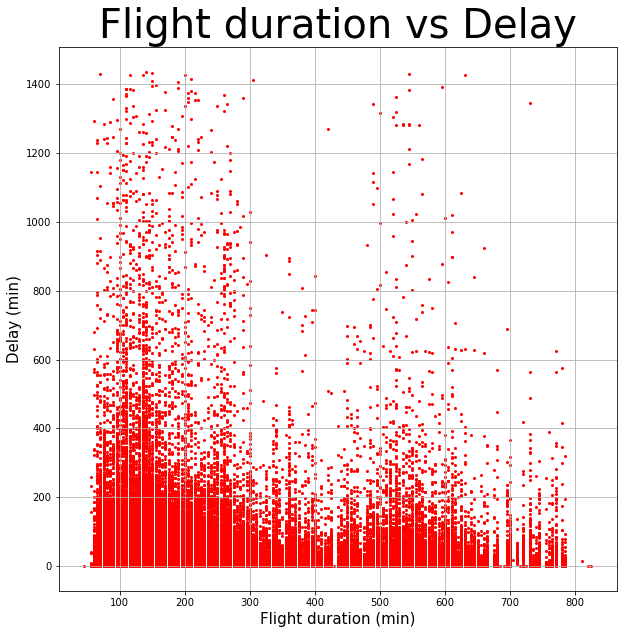

In [11]:
plt.figure(figsize=(10,10))
plt.scatter(data['Flight duration'], data['Delay'], s=4, c='red')
plt.xlabel('Flight duration (min)', fontsize=15)
plt.ylabel('Delay (min)', fontsize=15)
plt.title('Flight duration vs Delay', fontsize=40)
plt.grid()

# Outliers

In [12]:
data['Delay'].describe()                                                              # Statistic description

count    675513.000000
mean          9.912939
std          44.895875
min           0.000000
25%           0.000000
50%           0.000000
75%           5.000000
max        1436.000000
Name: Delay, dtype: float64

In [13]:
std = data['Delay'].std()
center = data['Delay'].mean()

Q_1 = data['Delay'].quantile(0.25)
Q_3 = data['Delay'].quantile(0.75)
Iqr = Q_3 - Q_1
criteria = 1.5

In [14]:
filter_data = data[data['Delay'] <=  (Q_3 + criteria * Iqr)]                                  # Apply Iqr criteria
outliers = data[data['Delay'] >  (Q_3 + criteria * Iqr)]

In [15]:
print(filter_data.shape,outliers.shape)                                                       # % of samples removed
print(len(filter_data)/len(data),len(outliers)/len(data))

(577040, 11) (98473, 11)
0.8542248631780588 0.14577513682194124


# One Hot Encoding Process

In [16]:
types = filter_data.columns                                                                    # Initial N of features 
len(types)

11

In [17]:
def ohe(Feature,data_name):
    encoder = OneHotEncoder(sparse=False)                                                       
    new_feats = encoder.fit_transform(data_name[[Feature]])
    new_cols = pd.DataFrame(new_feats, dtype=int,index=data_name.index) 
    new_cols.columns = encoder.get_feature_names([Feature])
    new_df = pd.concat([data_name, new_cols], axis=1)                                  
    new_df.drop(Feature, axis=1, inplace=True) 
    return new_df

In [18]:
filter_data = ohe('Depature Airport',filter_data)                                     # Ohe for each categorical variable
filter_data = ohe('Destination Airport',filter_data)
filter_data = ohe('Departure hour',filter_data)
filter_data = ohe('Arrival hour',filter_data)
filter_data = ohe('Departure week',filter_data)
filter_data = ohe('Arrival week',filter_data)

# Splitting Process

In [19]:
train = filter_data[filter_data['Departure date'] <= datetime.date(2017,12,31)]                    # Spliting the data by year
x_train, y_train = train.drop(['Delay', 'Departure date'], axis=1) , train['Delay']

test = filter_data[filter_data['Departure date'] >= datetime.date(2018,1,1)]
x_test , y_test = test.drop(['Delay', 'Departure date'], axis=1) , test['Delay']

In [20]:
print(len(x_train)/len(filter_data),len(x_test)/len(filter_data))                                  # % of training and test data

0.7201840427006794 0.2798159572993207


# Plot

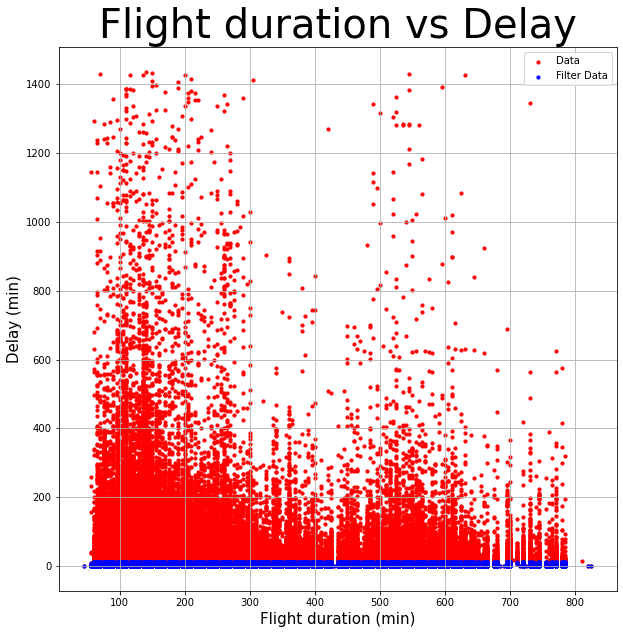

In [21]:
plt.figure(figsize=(10,10))
plt.scatter(data['Flight duration'], data['Delay'], s=10, c='red', label='Data')
plt.scatter(filter_data['Flight duration'], filter_data['Delay'], s=10, c='blue', label='Filter Data')
plt.xlabel('Flight duration (min)', fontsize=15)
plt.ylabel('Delay (min)', fontsize=15)
plt.title('Flight duration vs Delay', fontsize=40)
plt.grid()
plt.legend()

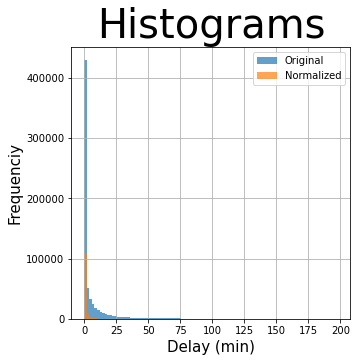

In [22]:
new =(data['Delay']-data['Delay'].mean())/data['Delay'].std()


ori = pd.Series(data['Delay'], name='v1')
nor = pd.Series(new, name='v2')


plt.figure(figsize=(5,5))
plt.hist(ori, alpha=0.7,  bins=np.arange(0,200,2), label='Original');
plt.hist(nor, alpha=0.7,  bins=np.arange(0,200,2), label='Normalized');
plt.xlabel('Delay (min)', fontsize=15)
plt.ylabel('Frequenciy', fontsize=15)
plt.title('Histograms', fontsize=40)
plt.legend();
plt.grid()

C:\Users\Mauro\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


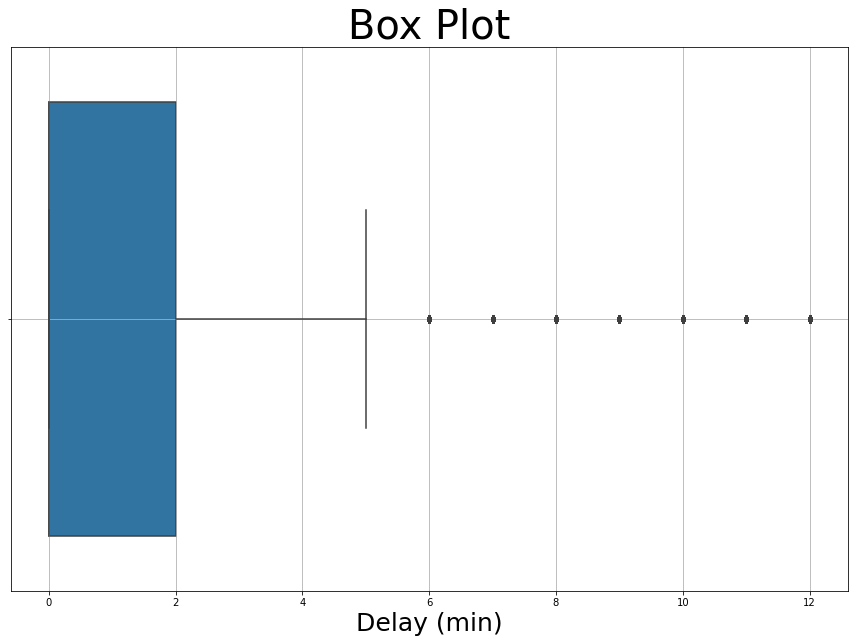

In [23]:
import seaborn as sns
plt.figure(figsize=(15,10))
plt.title('Box Plot', fontsize=40)
sns.boxplot(filter_data['Delay'])
plt.xlabel('Delay (min)', fontsize=25)
plt.grid()

# Simple Linear Regression

In [24]:
def slr(X_train,Y_train,X_test,Y_test):
    
    xtrain = X_train
    xtest = X_test
    y_train = Y_train
    y_test = Y_test
    
    dimensions = len(xtrain.columns)
    ndim = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]

    for n in ndim:
        dim_red = int(dimensions * n)
        pca = PCA(n_components=(dim_red))
        pca.fit(xtrain)
        x_train, x_test = pca.transform(xtrain), pca.transform(xtest)
        
        regressor = LinearRegression()                                                                   
        regressor.fit(x_train, y_train)                                          
                                                                           
        y_pred_train = regressor.predict(x_train)                                 
        y_pred_test = regressor.predict(x_test) 

        print('MSE Train: ' + str(metrics.mean_squared_error(y_train, y_pred_train)) + ' ndim reducted = ' + str(1-n))
        print('MSE Test: ' + str(metrics.mean_squared_error(y_test, y_pred_test)) + ' ndim reducted = ' + str(1-n))
        print()
        print('RMSE Train: ' + str(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))) + ' ndim reducted = ',str(1-n))
        print('RMSE Test :' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))) + ' ndim reducted = ',str(1-n))
        print()
        print('MAE Train: ' + str(metrics.mean_absolute_error(y_train, y_pred_train)) + ' ndim reducted = ' + str(1-n))
        print('MAE Test: ' + str(metrics.mean_absolute_error(y_test, y_pred_test)) + ' ndim reducted = ' + str(1-n))
        print()

In [25]:
slr(x_train,y_train,x_test,y_test)

MSE Train: 8.667851760522886 ndim reducted = 0.0
MSE Test: 5.647226450864973 ndim reducted = 0.0

RMSE Train: 2.9441215600791497 ndim reducted =  0.0
RMSE Test :2.376389372738603 ndim reducted =  0.0

MAE Train: 2.19215665094446 ndim reducted = 0.0
MAE Test: 1.943411082520504 ndim reducted = 0.0

MSE Train: 8.66792581432121 ndim reducted = 0.09999999999999998
MSE Test: 5.64717719516348 ndim reducted = 0.09999999999999998

RMSE Train: 2.9441341366047182 ndim reducted =  0.09999999999999998
RMSE Test :2.3763790091573105 ndim reducted =  0.09999999999999998

MAE Train: 2.192194095114927 ndim reducted = 0.09999999999999998
MAE Test: 1.943393803969719 ndim reducted = 0.09999999999999998

MSE Train: 8.67216024185604 ndim reducted = 0.19999999999999996
MSE Test: 5.646299966182092 ndim reducted = 0.19999999999999996

RMSE Train: 2.944853178319089 ndim reducted =  0.19999999999999996
RMSE Test :2.3761944293727506 ndim reducted =  0.19999999999999996

MAE Train: 2.1928200740368378 ndim reducted 

# Ridge -Lasso Regression

In [30]:
def dim_red(X_train, X_test, Y_train, Y_test, M):
    
    ridge = Ridge()
    lasso = Lasso()
    
    if M == 1:
       Method = Ridge
       method = ridge
       Name = "Ridge_Method"
        
    elif M == 2:
       Method = Lasso
       method = lasso
       Name = "Lasso_Method"
    
    alphas = [0.00000001, 0.001, 0.5, 1, 1.5, 2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50]
    ndim = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]  
    
    xtrain = X_train
    xtest = X_test
    ytrain = Y_train
    ytest = Y_test
                           
    dimensions = len(xtrain.columns)
    
    for n in ndim:
        dim_red = int(dimensions * n)

        pca = PCA(n_components=(dim_red))
        pca.fit(xtrain)
        x_train, x_test = pca.transform(xtrain), pca.transform(xtest)

        losses_train_mse = []
        losses_test_mse = []

        losses_train_mae = []
        losses_test_mae = []

        losses_train_rmse = []
        losses_test_rmse = []
    
        for alpha in alphas:
            
            method = Method(alpha=alpha)
            method.fit(x_train, y_train)
    
            y_pred_train = method.predict(x_train)
            y_pred_test = method.predict(x_test)
    
            losses_train_mse.append(metrics.mean_squared_error(y_pred_train, y_train))
            losses_test_mse.append(metrics.mean_squared_error(y_pred_test, y_test))
    
            losses_train_mae.append(metrics.mean_absolute_error(y_pred_train, y_train))
            losses_test_mae.append(metrics.mean_absolute_error(y_pred_test, y_test))
    
            losses_train_rmse.append(np.sqrt(metrics.mean_squared_error(y_pred_train, y_train)))
            losses_test_rmse.append(np.sqrt(metrics.mean_squared_error(y_pred_test, y_test)))
        
        plt.figure(figsize=(30,10))
        plt.plot(alphas, losses_train_mse, '>', markersize=10, c='blue', label='Training MSE')
        plt.plot(alphas, losses_test_mse, '>', markersize=10, c='red', label='Test MSE')
        plt.plot(alphas, losses_train_mae, "*", markersize=10, c='blue', label='Training MAE')
        plt.plot(alphas, losses_test_mae, "*", markersize=10, c='red', label='Test MAE')
        plt.plot(alphas, losses_train_rmse, 'o', markersize=10, c='blue', label='Training RMSE')
        plt.plot(alphas, losses_test_rmse, 'o', markersize=10, c='red', label='Test RMSE')
        plt.title(Name + " alpha value selection with " + str(int((1-n)*100)) +"% of dimensions reducted", fontsize=20)
        plt.xlabel("Alpha", fontsize=25)
        plt.ylabel("Metric Error", fontsize=25)
        plt.legend()
        plt.grid()
        #plt.savefig(Name + ' reduction ' + str(n) + ' errors.png')   
        
    return 

C:\Users\Mauro\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.81256e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


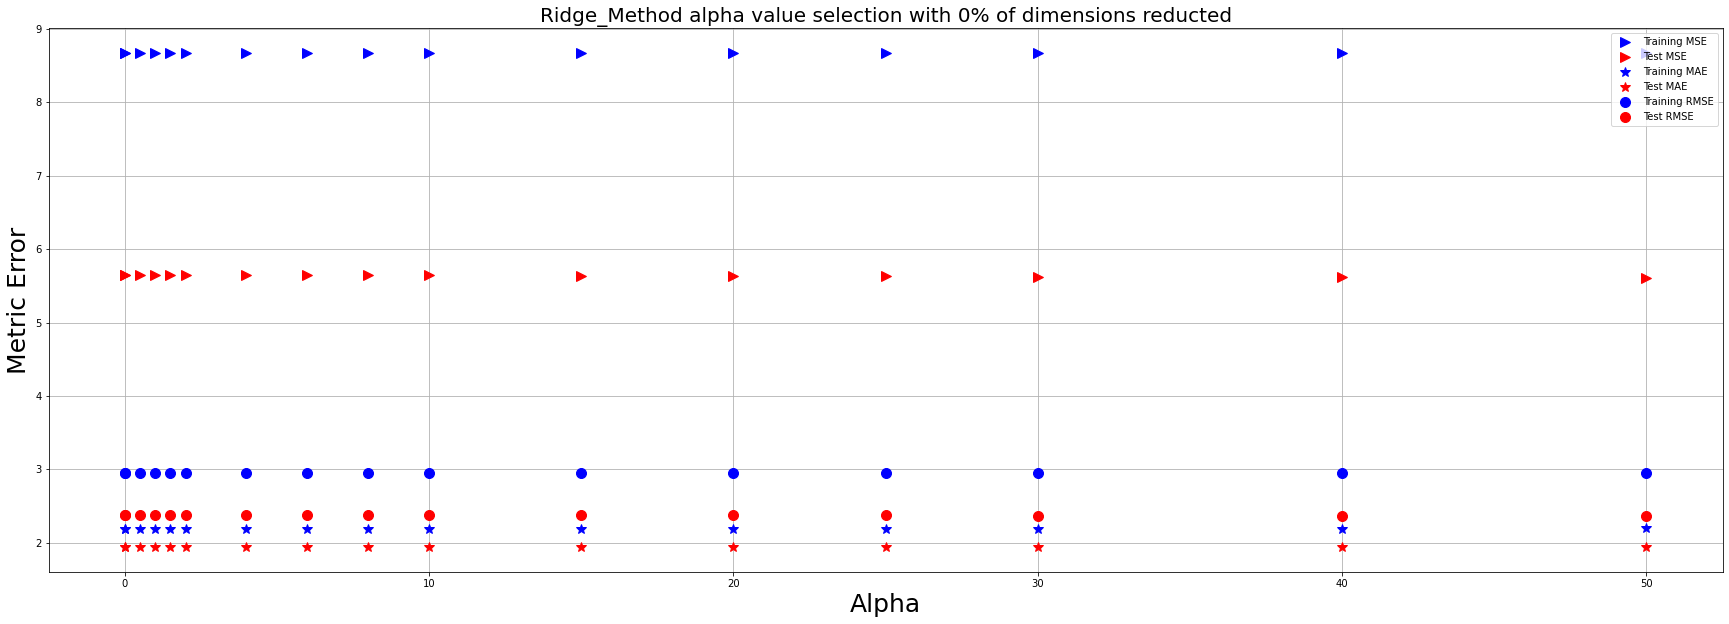

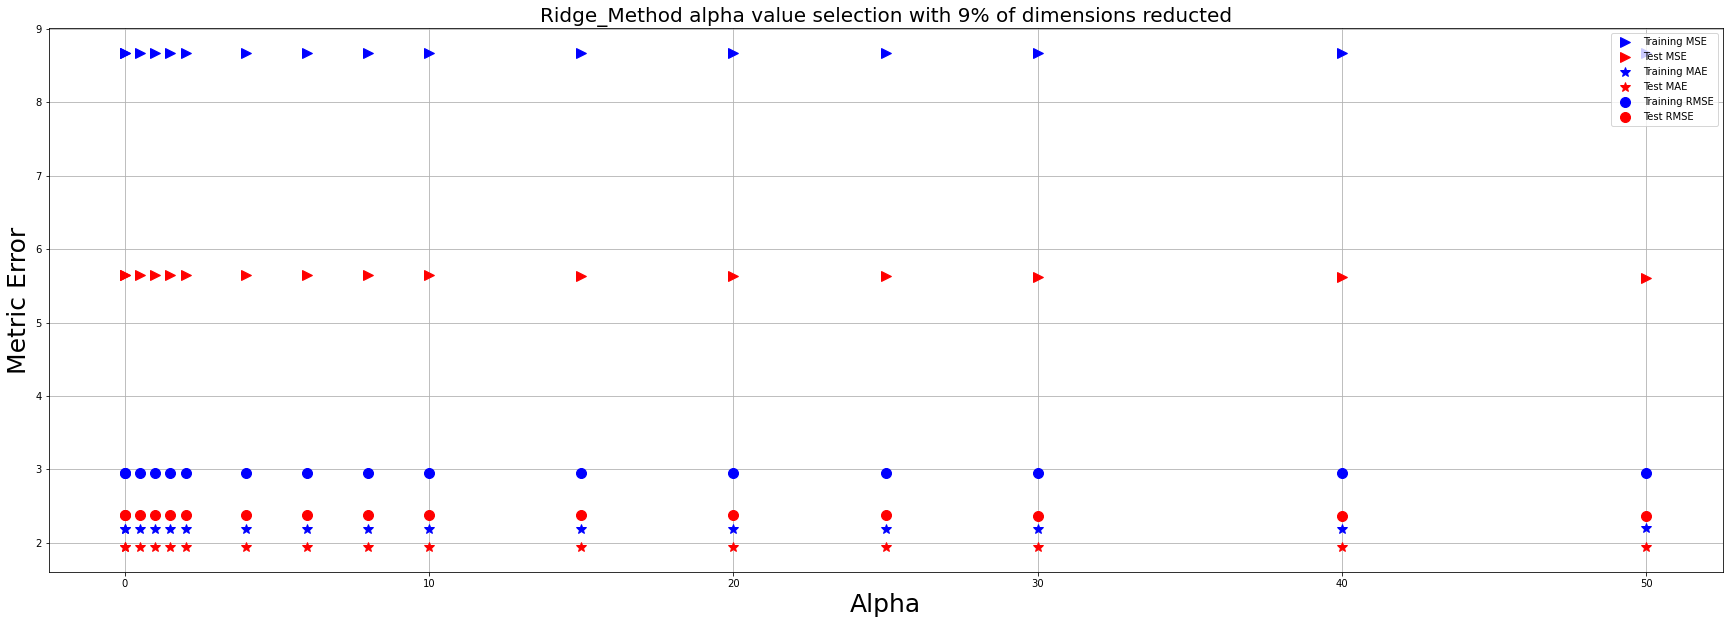

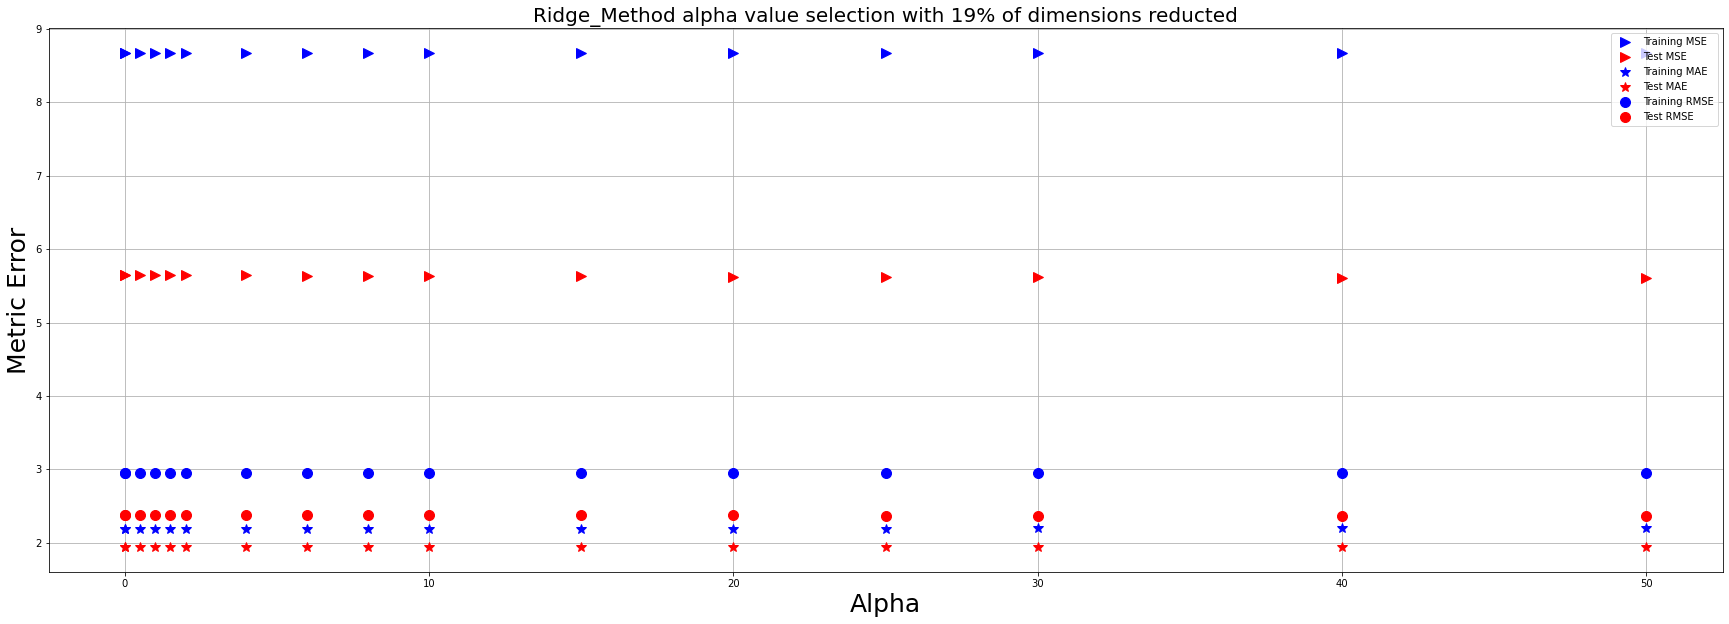

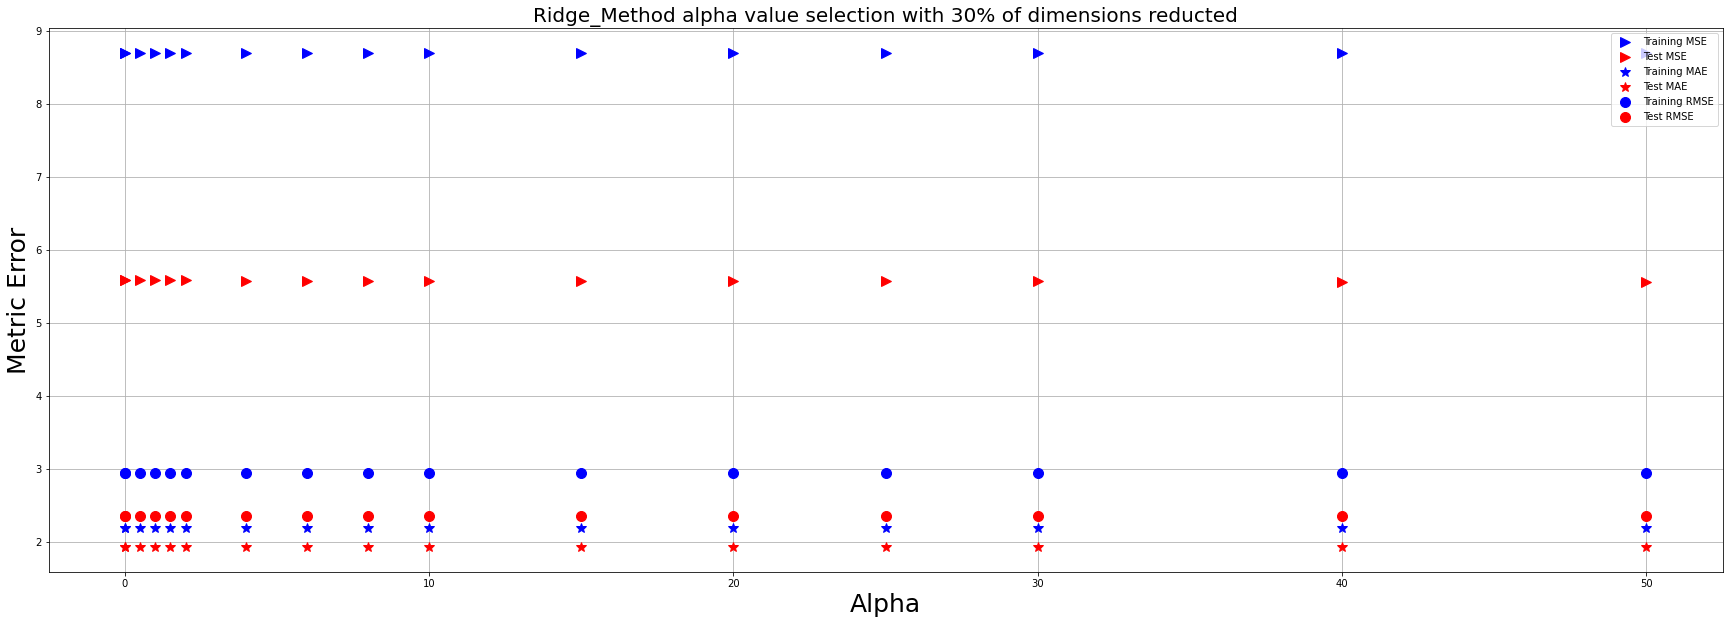

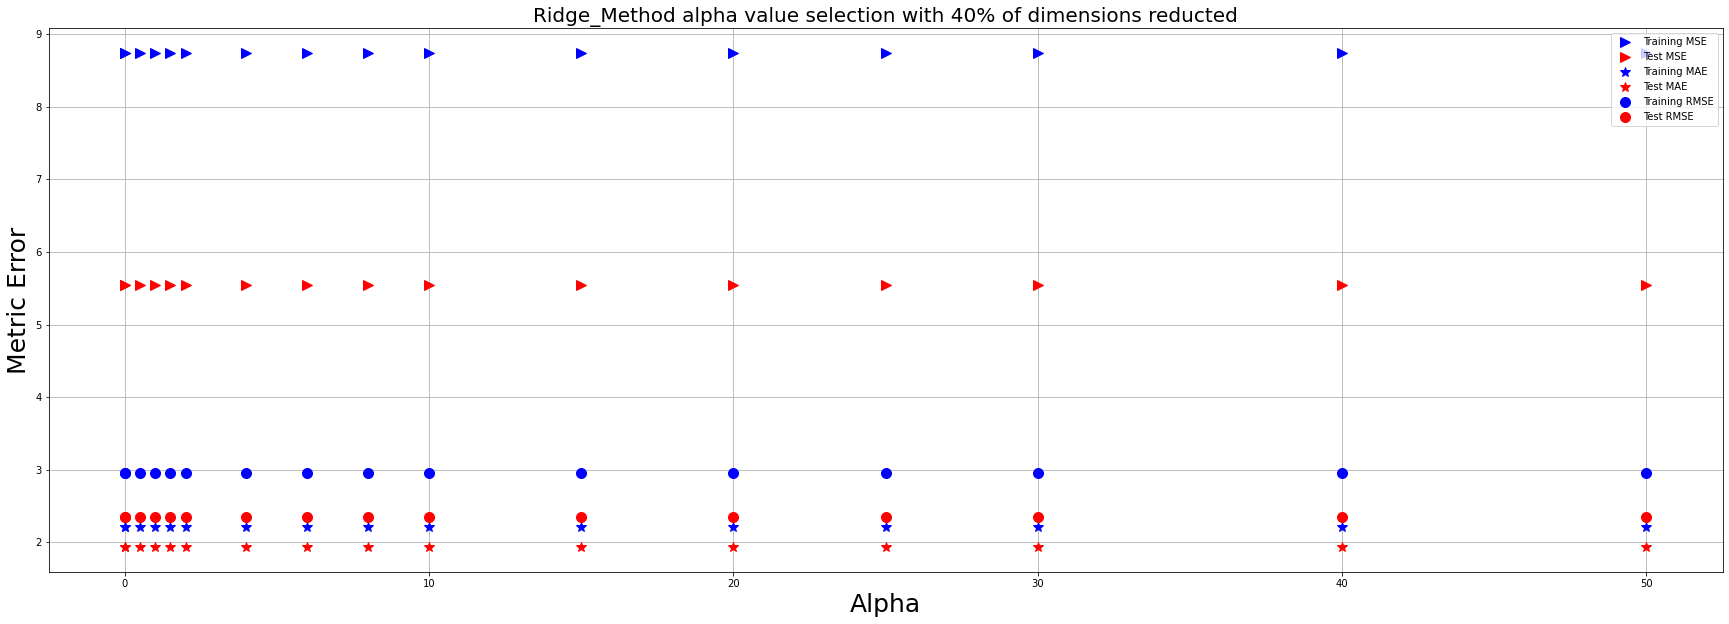

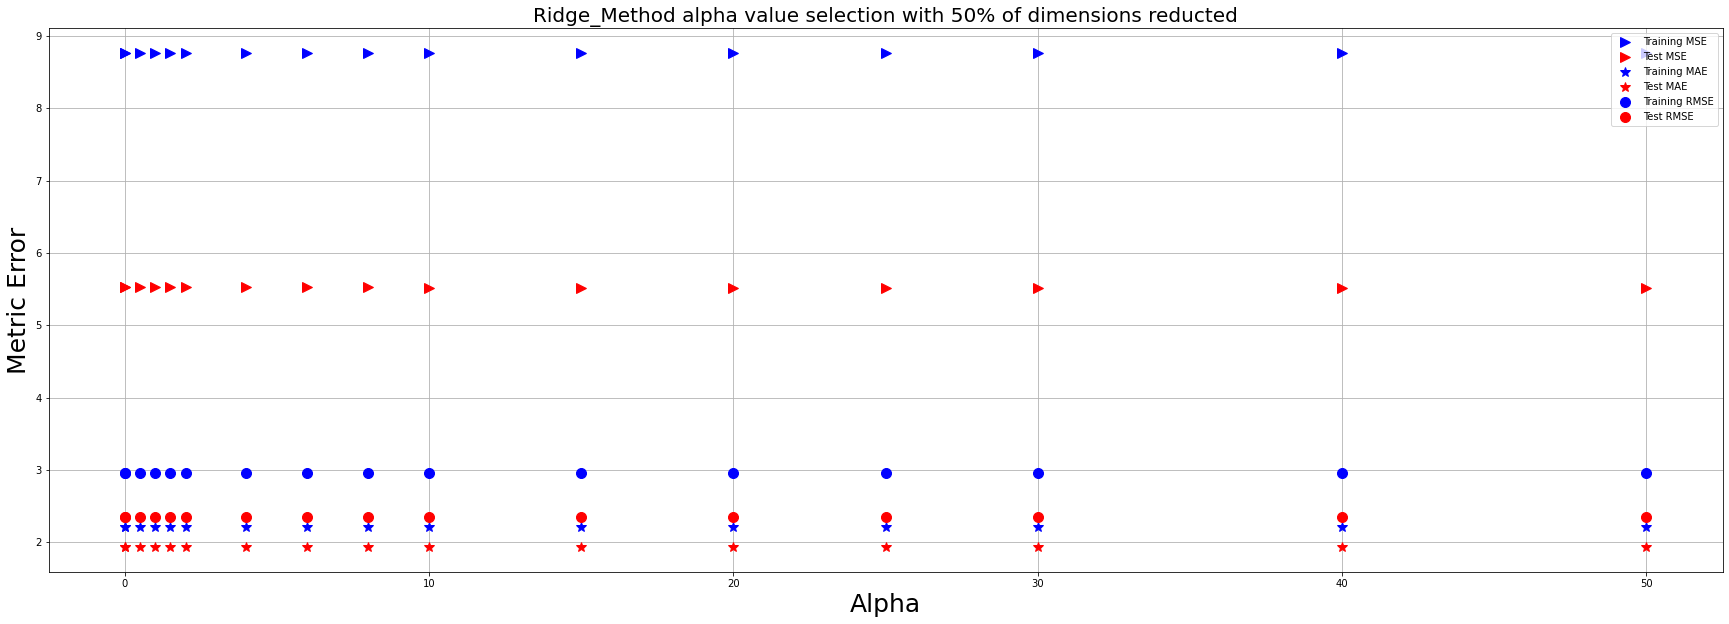

In [31]:
dim_red(x_train, x_test, y_train, y_test, 1)

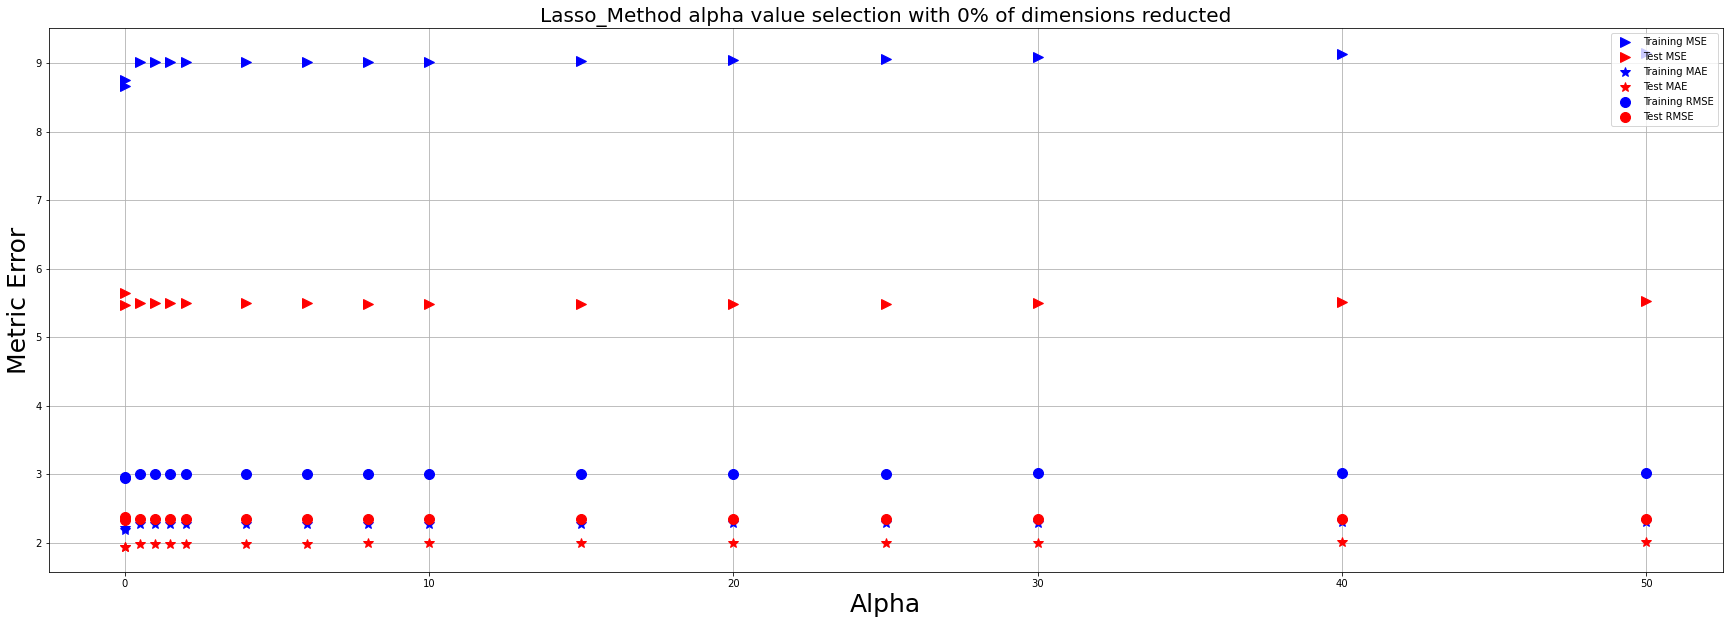

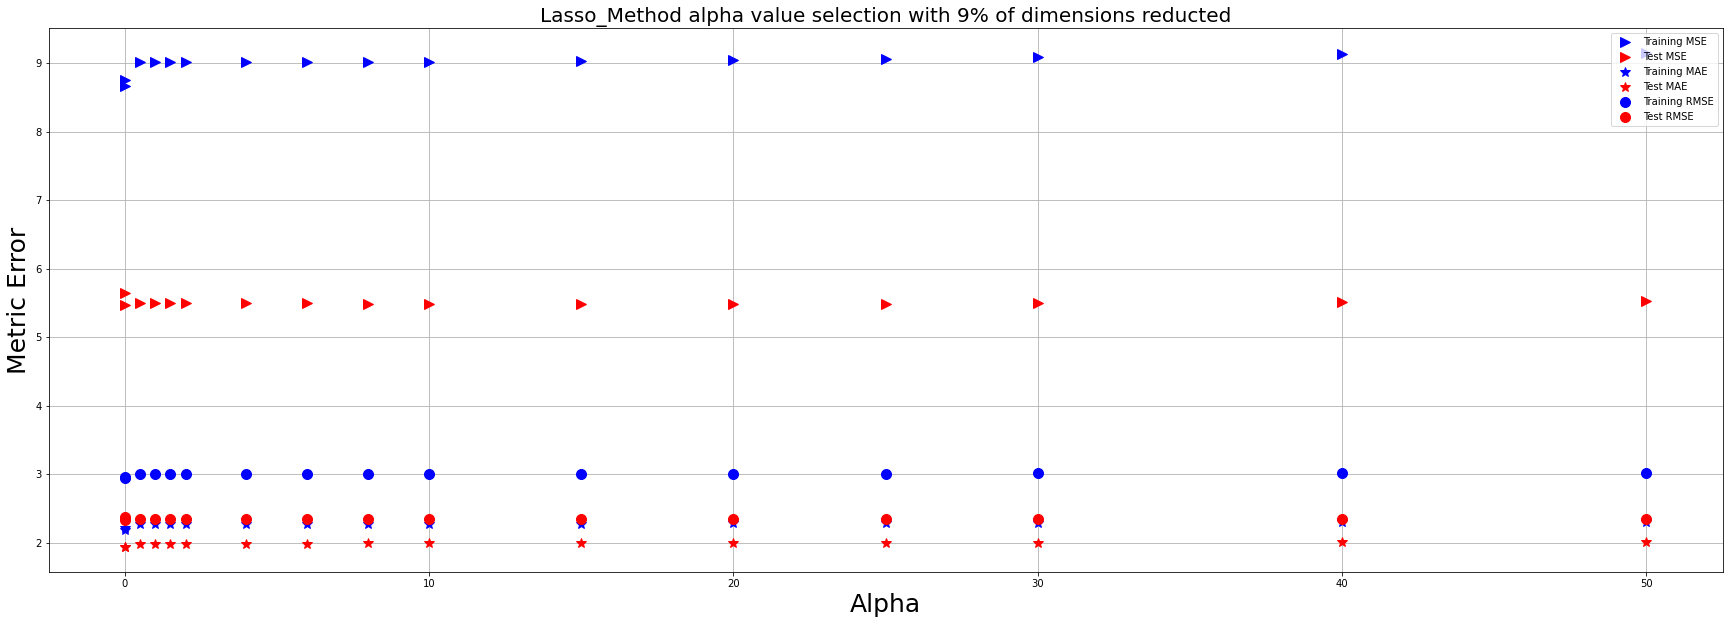

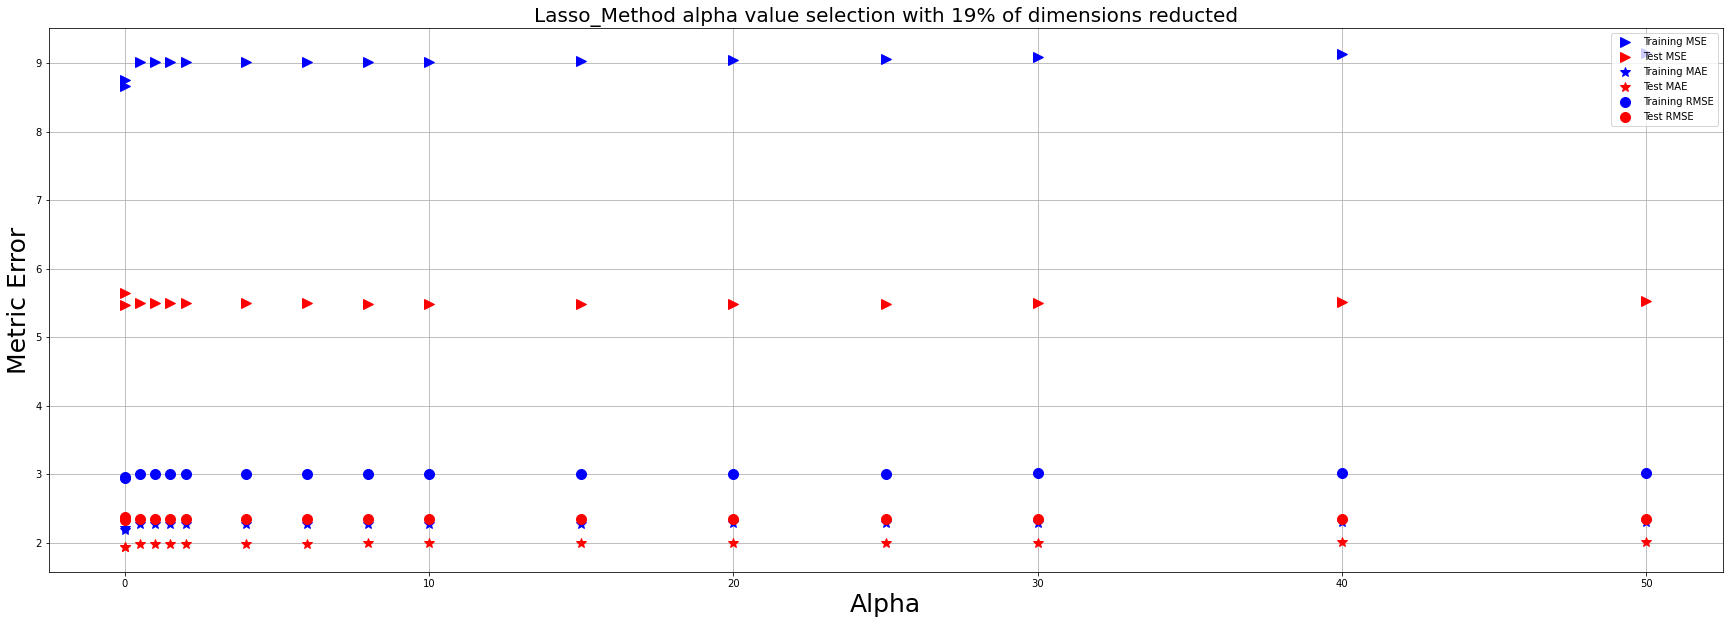

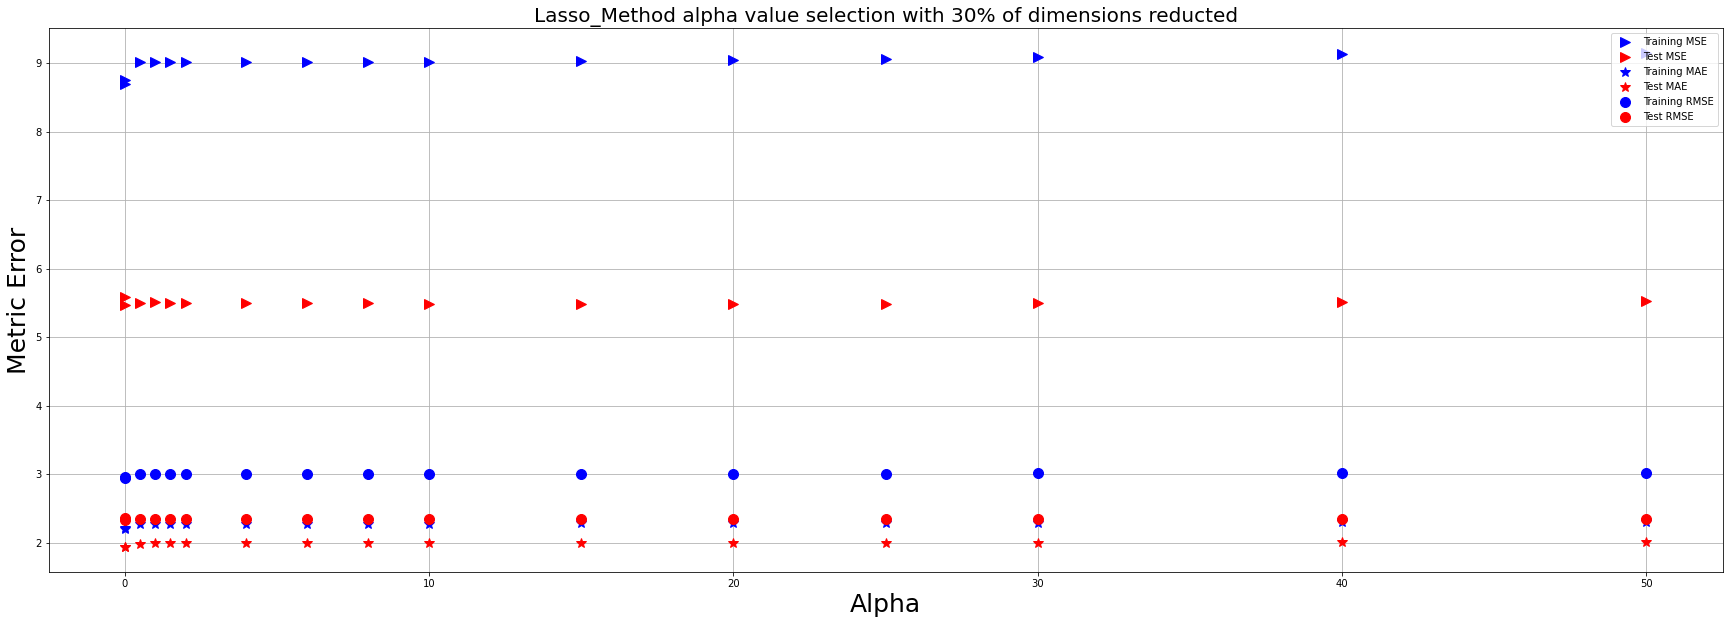

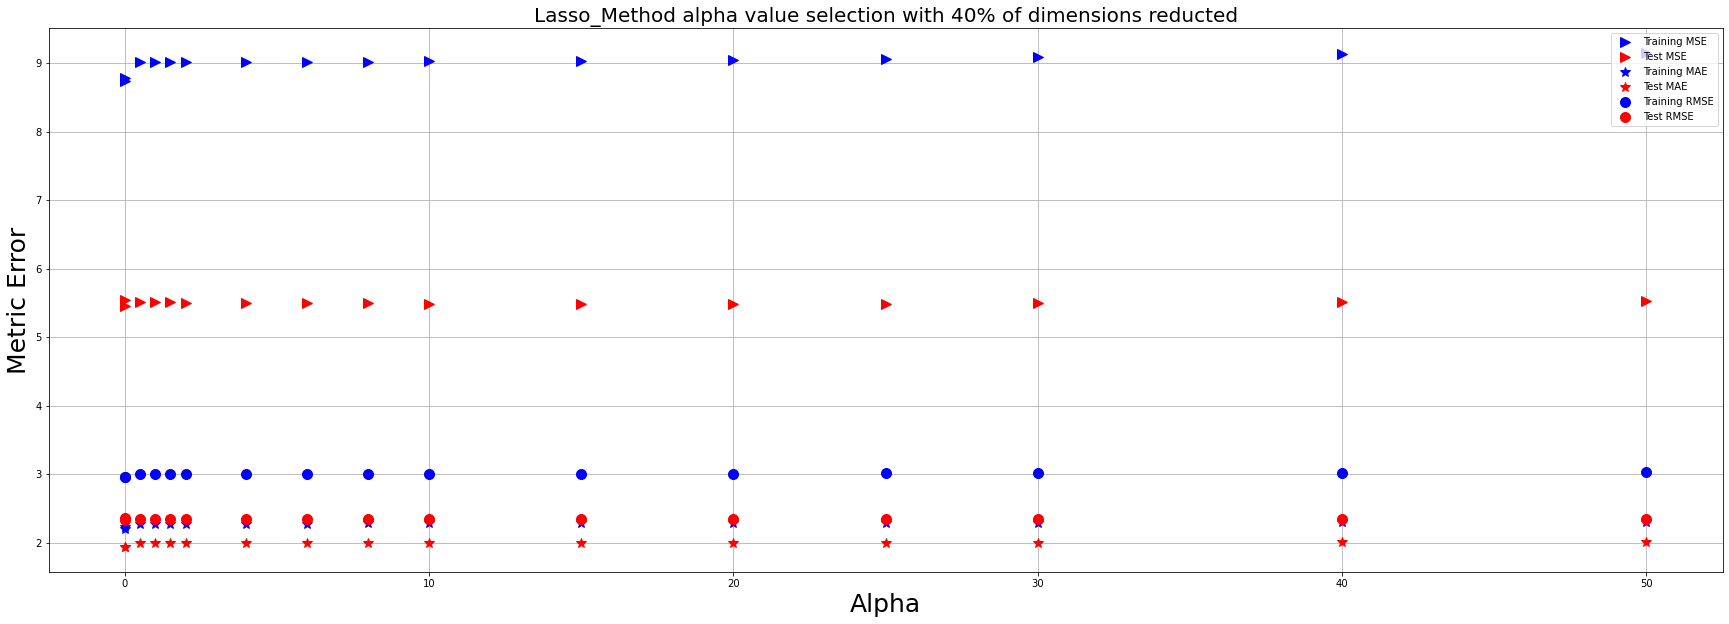

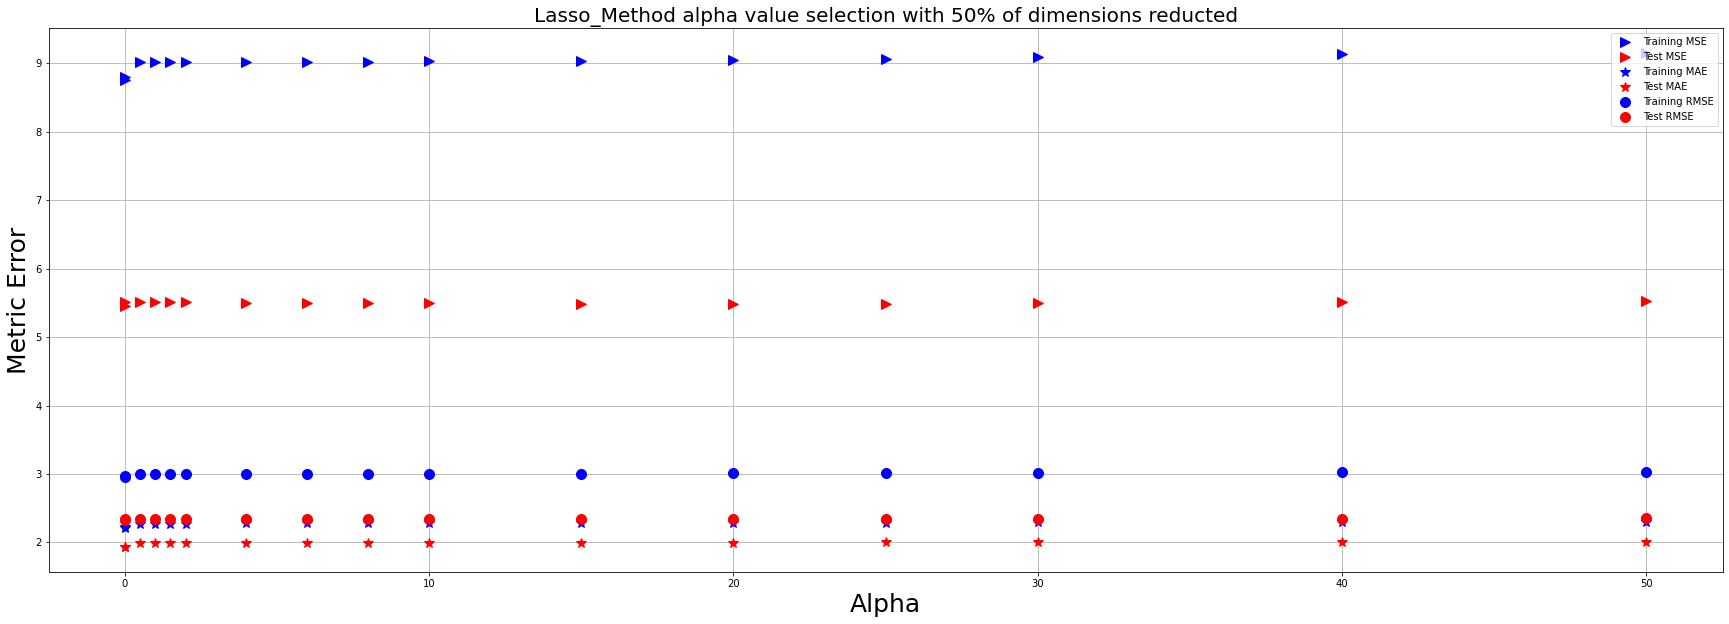

In [32]:
dim_red(x_train, x_test, y_train, y_test, 2)

# Ridge - Lasso Regression with Polynomial Features

In [33]:
def dim_redn(X_train, X_test, Y_train, Y_test, M):
    
    ridge = Ridge()
    lasso = Lasso()
    Degrees = 2
    
    if M == 1:
       Method = Ridge
       method = ridge
       Name = "Ridge_Method"
        
    elif M == 2:
       Method = Lasso
       method = lasso
       Name = "Lasso_Method"
    
    alphas = alphas = [0.001, 0.5, 1, 1.5, 2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50]
    ndim = [0.1, 0.05]  
    
    xtrain = X_train
    xtest = X_test
    ytrain = Y_train
    ytest = Y_test
                           
    dimensions = len(xtrain.columns)
    
    for n in ndim:
        dim_red = int(dimensions * n)

        pca = PCA(n_components=(dim_red))
        pca.fit(xtrain)
        x_train, x_test = pca.transform(xtrain), pca.transform(xtest)
        
        poly = PolynomialFeatures(2)
        poly.fit(x_train)
        x_trainp = poly.transform(x_train)
        x_testp = poly.transform(x_test)
        

        losses_train_mse = []
        losses_test_mse = []

        losses_train_mae = []
        losses_test_mae = []

        losses_train_rmse = []
        losses_test_rmse = []
    
        for alpha in alphas:
            
            method = Method(alpha=alpha)
            method.fit(x_trainp, y_train)
    
            y_pred_train = method.predict(x_trainp)
            y_pred_test = method.predict(x_testp)
    
            losses_train_mse.append(metrics.mean_squared_error(y_pred_train, y_train))
            losses_test_mse.append(metrics.mean_squared_error(y_pred_test, y_test))
    
            losses_train_mae.append(metrics.mean_absolute_error(y_pred_train, y_train))
            losses_test_mae.append(metrics.mean_absolute_error(y_pred_test, y_test))
    
            losses_train_rmse.append(np.sqrt(metrics.mean_squared_error(y_pred_train, y_train)))
            losses_test_rmse.append(np.sqrt(metrics.mean_squared_error(y_pred_test, y_test)))
        
        plt.figure(figsize=(30,10))
        plt.plot(alphas, losses_train_mse, '>', markersize=10, c='blue', label='Training MSE')
        plt.plot(alphas, losses_test_mse, '>', markersize=10, c='red', label='Test MSE')
        plt.plot(alphas, losses_train_mae, "*", markersize=10, c='blue', label='Training MAE')
        plt.plot(alphas, losses_test_mae, "*", markersize=10, c='red', label='Test MAE')
        plt.plot(alphas, losses_train_rmse, 'o', markersize=10, c='blue', label='Training RMSE')
        plt.plot(alphas, losses_test_rmse, 'o', markersize=10, c='red', label='Test RMSE')
        plt.title(Name + " alpha value selection with " + str(int((1-n)*100)) +"% of dimensions reducted to n =2", fontsize=20)
        plt.xlabel("Alpha", fontsize=25)
        plt.ylabel("Metric Error", fontsize=25)
        plt.legend()
        plt.grid()
        #plt.savefig(Name + ' reduction ' + str(n) + "% of dimensions reducted to n =2"+ ' errors.png')   
        
        
    return 

C:\Users\Mauro\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.40841e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Mauro\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.85851e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


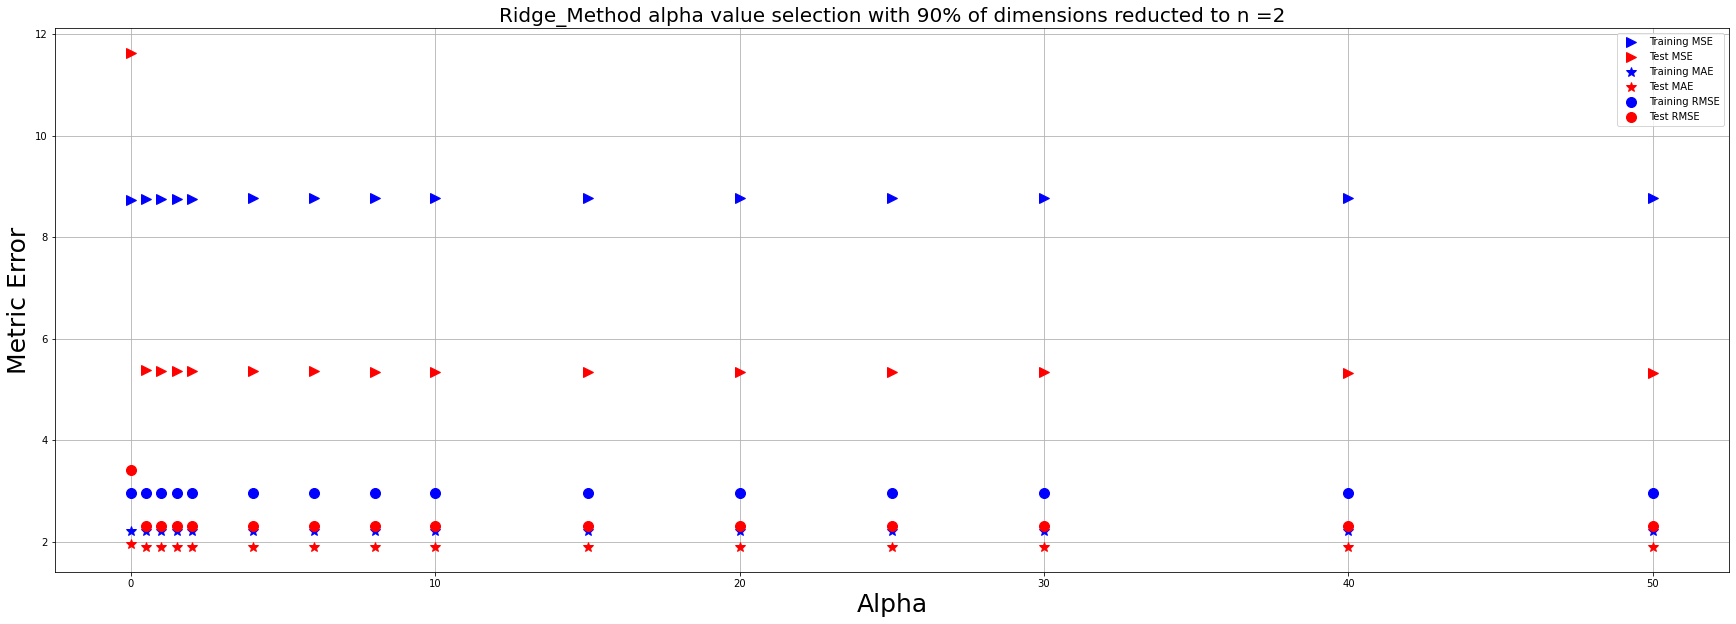

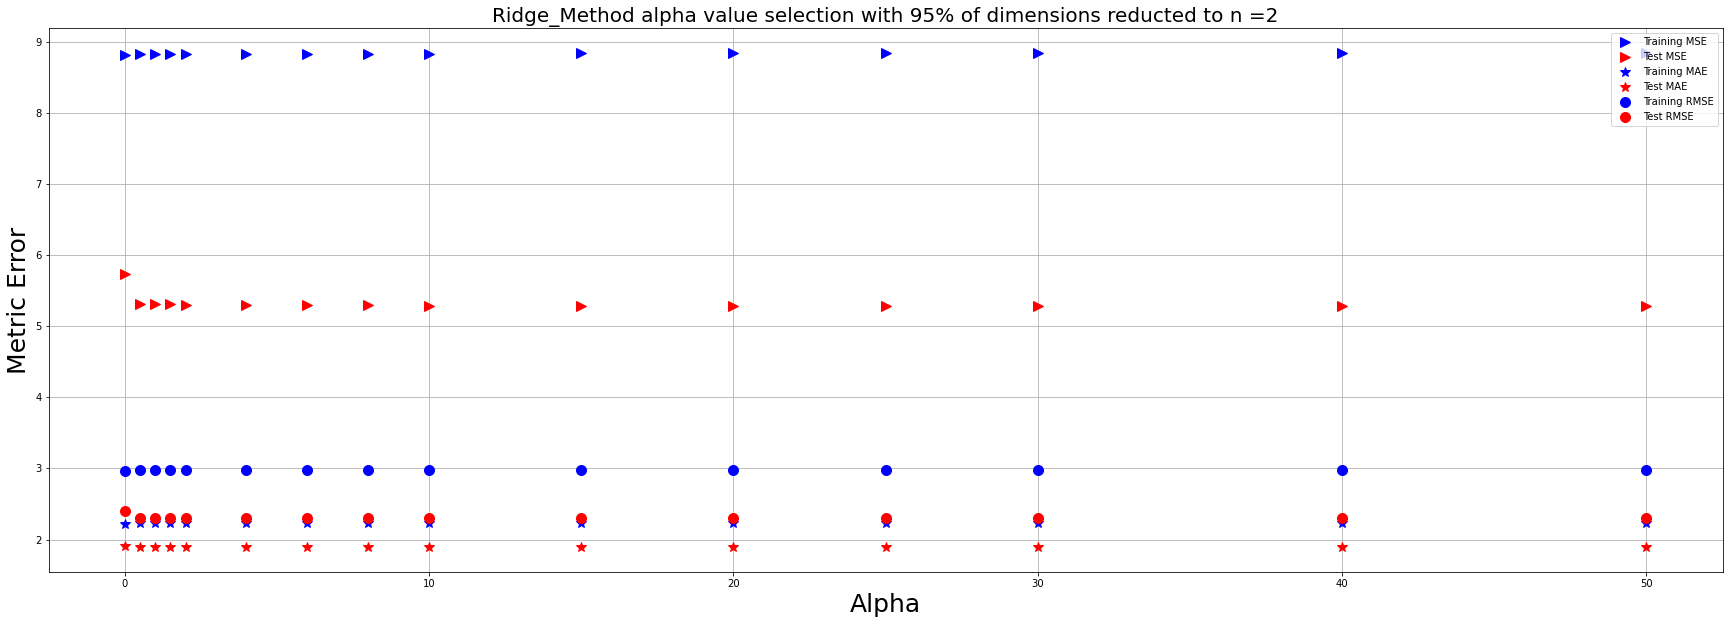

In [34]:
dim_redn(x_train, x_test, y_train, y_test, 1)

C:\Users\Mauro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1494875.908820078, tolerance: 380.39464987887817
  model = cd_fast.enet_coordinate_descent(
C:\Users\Mauro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4930.01982321078, tolerance: 380.39464987887817
  model = cd_fast.enet_coordinate_descent(


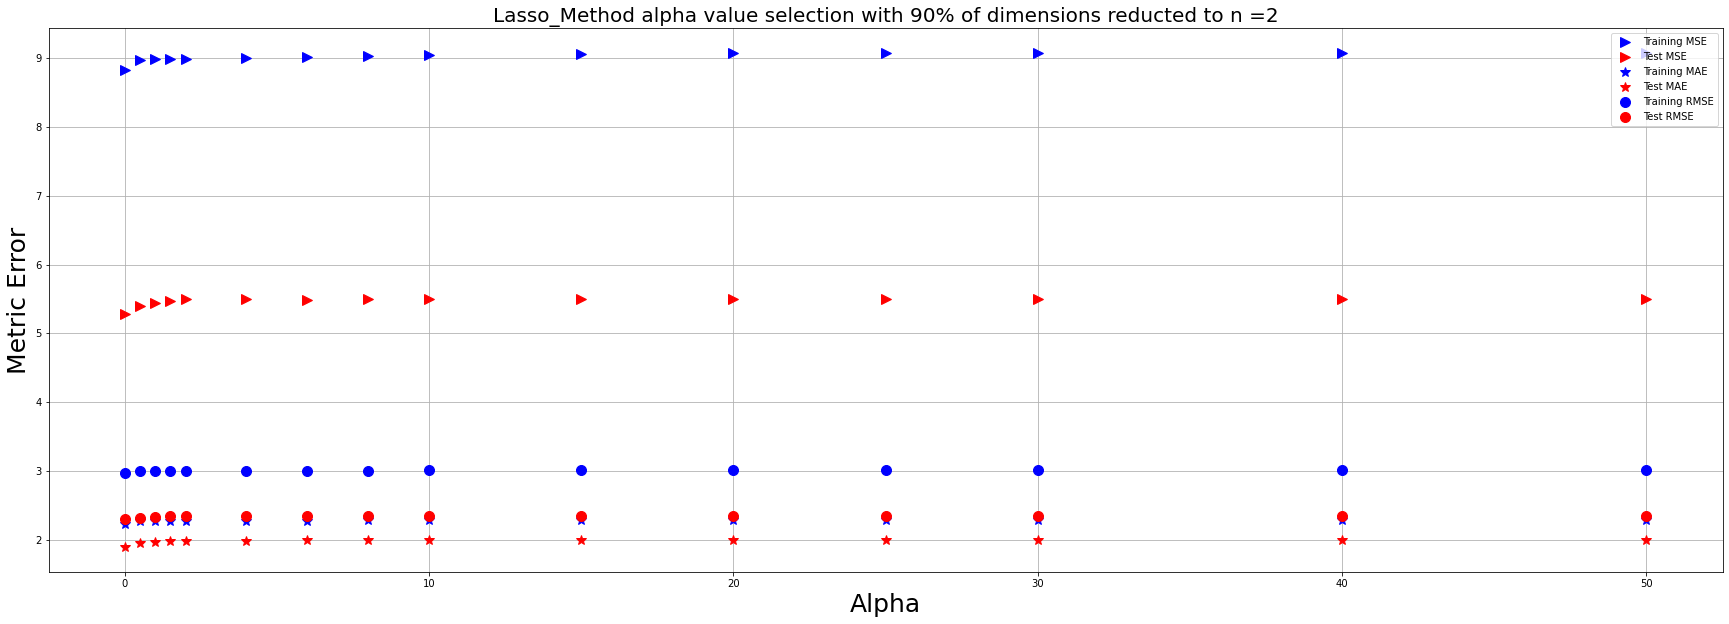

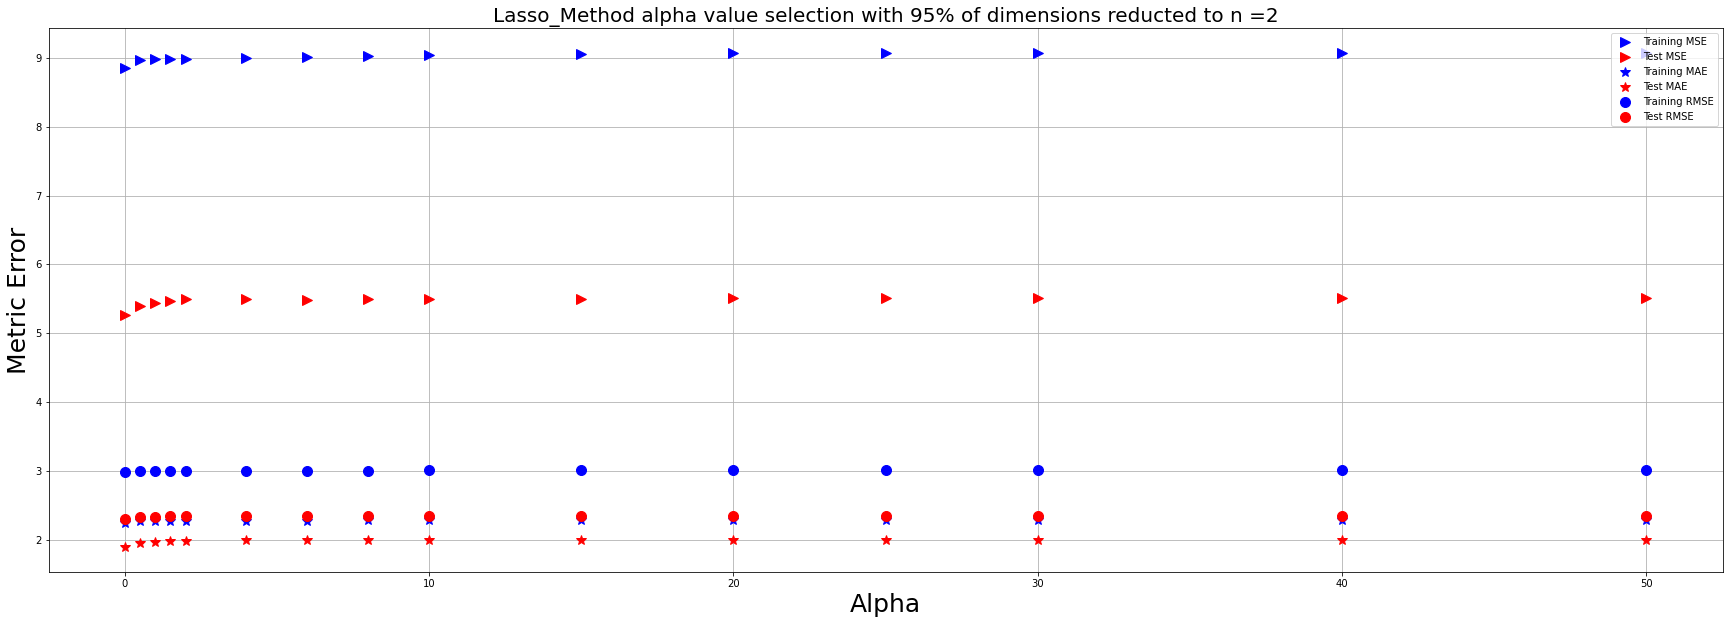

In [35]:
dim_redn(x_train, x_test, y_train, y_test, 2)